In [15]:
import numpy as np
import math 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import quad
from numba import cfunc, njit
%matplotlib notebook

In [16]:
@njit
def thomasAlgorithm(A, d):  # Tridiagonal matrix algorithm . Или метод прогонки
    n = len(d)
    P = np.zeros(n - 1)
    Q = np.zeros(n - 1)
    x = np.zeros(n)
    P[0] = A[0][1] / -A[0][0]
    Q[0] = -d[0] / -A[0][0]
    for i in range(1, n - 1):  # находим прогоночные коэффициенты
        a = A[i][i - 1]
        b = A[i][i]
        c = A[i][i + 1]

        P[i] = c / (-b - a * P[i - 1])
        Q[i] = (a * Q[i - 1] - d[i]) / (-b - a * P[i - 1])
    x[-1] = (A[n - 1][n - 2] * Q[n - 2] - d[n - 1]) / (-A[n - 1][n - 1] - A[n - 1][n - 2] * P[n - 2])
    for i in range(n - 2, -1, -1):  # Находим неизвекстные
        x[i] = P[i] * x[i + 1] + Q[i]
    return x

In [17]:
D = 0.5  # Коэффициент миграции
a = 2.0  # Коэффициент рождения новых людей
sourceKoeff = 2.0  # Ёмкость среды
deathKoeff = 1.  # Коэффициент смертность населения

N = 100  # количество точек по оси OX (Площадь занимаемая людьми)
x0 = 0.  # начало отрезка
L = 100.  # конец отрезка
h = (L - x0) / (N - 1)  # шаг по OX

KT = 1000  # количество точек по времени
t0 = 0.  # начальный момент времени
T = 100.  # конечный момент времени
tau = (T - t0) / (KT - 1)  # шаг по времени

sigma = tau * D / h ** 2  # sigma - число Куранта

In [18]:
@njit
def solutionMatrixStart():  # заполнение матрицы решений краевыми условиями
    x = np.linspace(x0, L, N)
    u = np.zeros((N, KT))
    for i in range(0, N):
        u[i][0] = math.exp(-(i) ** 2)
        u[i][-1] = 0
    return u, x

In [19]:
def createAndSolveMatrix(allSourceFraction):  # заполняем трехдиагональную матрицу Ax=d
    A = np.zeros((N - 2, N - 2))
    d = np.zeros((N - 2))
    u, x = solutionMatrixStart()
    # print(u)
    for i in range(1, KT):
        A[0, 0] = - 2 * sigma - (a * tau * allSourceFraction.ctypes(u[1][i - 1], i, u[1][i - 1])) - deathKoeff * tau - 1
        A[0, 1] = sigma
        d[0] = (a * tau + 1) * (-u[1][i - 1]) - sigma * u[0][i]

        for j in range(1, N - 3):
            A[j, j - 1] = sigma
            A[j, j] = - 2 * sigma - (
                    a * tau * allSourceFraction.ctypes(u[j + 1][i - 1], i, u[j][i - 1])) - deathKoeff * tau - 1
            A[j, j + 1] = sigma
            d[j] = (a * tau + 1) * (-u[j + 1][i - 1])

        A[N - 3, N - 3] = - 2 * sigma - (
                a * tau * allSourceFraction.ctypes(u[N - 2][i - 1], i, u[N - 2][i - 1])) - deathKoeff * tau - 1
        A[N - 3, N - 4] = sigma
        d[N - 3] = (a * tau + 1) * (-u[N - 2][i - 1]) - sigma * u[N - 1][i]
        # print (A,d)
        u[1:N - 1, i] = thomasAlgorithm(A, d)
        # print(u)
    return u, x

$$F(u)=au^k_j\cdot(1-u^{k+1}_j/K)- \sigma u^{k+1}_j$$

In [20]:
K1 = 12


def allSourceFraction(numerator, i, u1):
    integrall_tmp = quad(lambda x: u1, 0, tmh.L)[0]
    F = K1 + tmh.sourceKoeff * integrall_tmp
    return integrall_tmp/F

u, x = createAndSolveMatrix(allSourceFraction)
print("\nФункция по которой считаем доступные ресурсы T(I)= " + str(tmh.sourceKoeff) + " + " + str(K1) +" * integral(u(x,t)*dx)")
#print(u.max())

AttributeError: 'function' object has no attribute 'ctypes'

In [21]:
print("D = " + str(D) + ' a = ' + str(a) + " smert = " + str(smert) + " K0 = " + str(K) + " K1 = " + str(K1))
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 1000000) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=100)
plt.grid(True)
plt.show()

NameError: name 'smert' is not defined

In [24]:
@njit
def allSourceFraction(numerator, i, u1=0): 
    denominator = 6000/i*sourceKoeff
    return numerator/denominator

u, x = createAndSolveMatrix(allSourceFraction)

AttributeError: 'CPUDispatcher' object has no attribute 'ctypes'

<IPython.core.display.Javascript object>


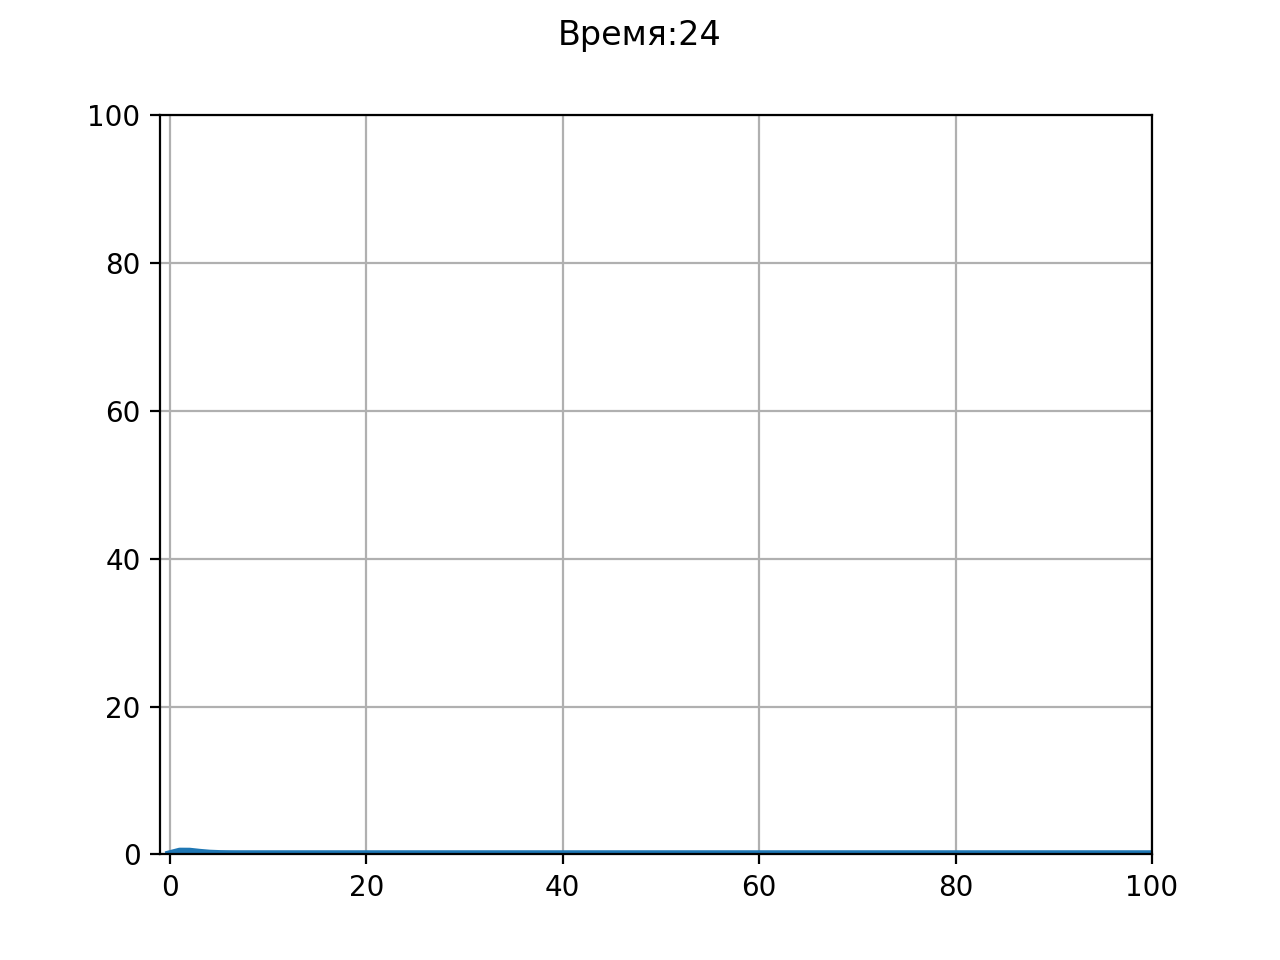

In [23]:
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 100) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=100)
plt.grid(True)
plt.show()

In [25]:
@cfunc("float64(float64, float64, float64)")
def allSourceFraction(numerator, i, u1): 
    return numerator/sourceKoeff

u, x = createAndSolveMatrix(allSourceFraction)

<IPython.core.display.Javascript object>


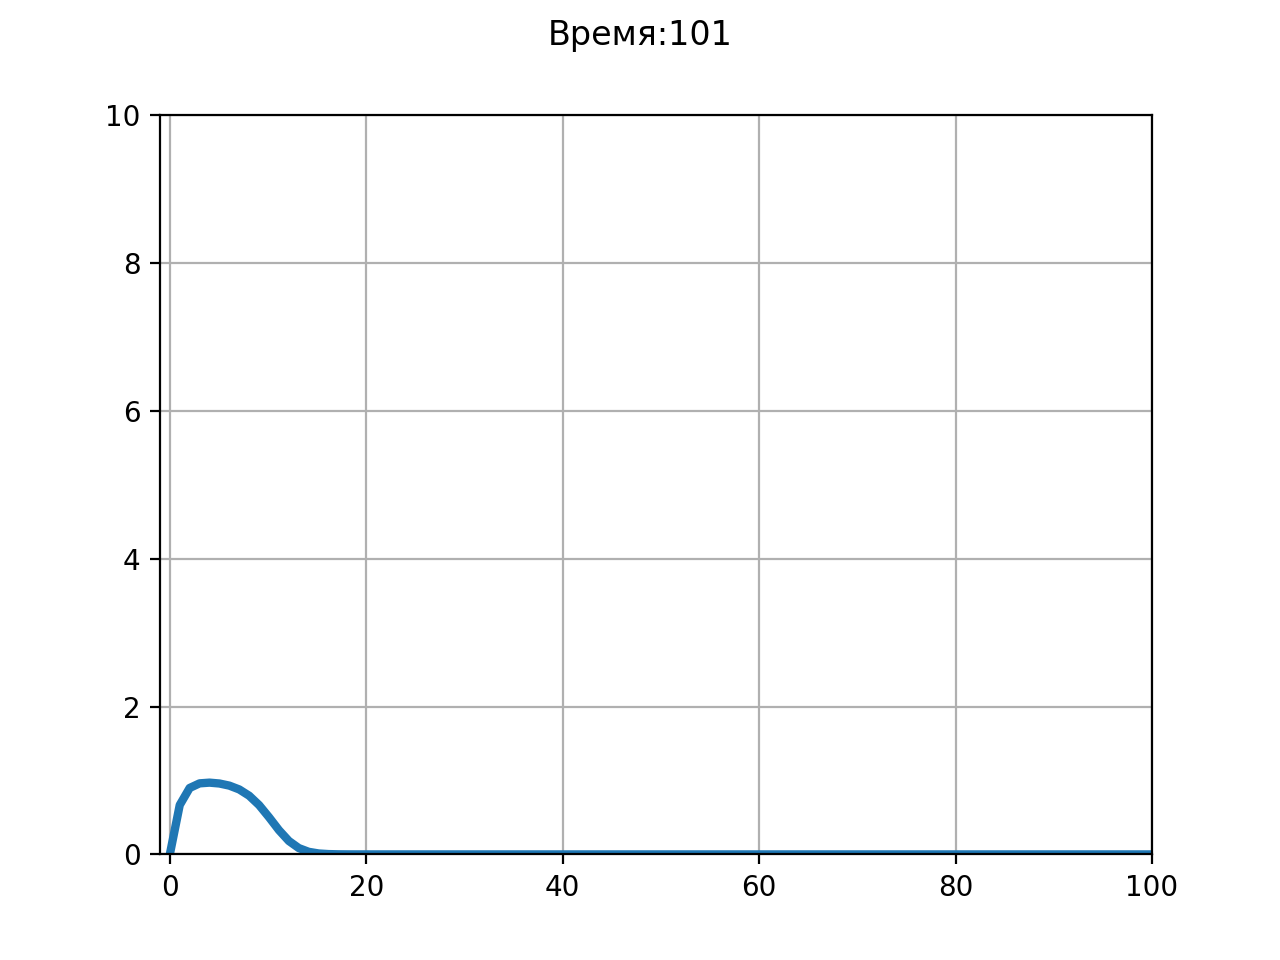

In [26]:
#print("D = " + str(D) + ' a = ' + str(a) + " smert = " + str(smert) + " K0 = " + str(K) )
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 10) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=100)
plt.grid(True)
plt.show()

In [18]:
K = 10
K1 = 1

def KTI(i, u1): return K + K1 * integrate(u1, (x1, x0, L))

u, x = createAndSolveMatrix(KTI)

D = 0.5 a = 2.0 smert = 1.0 K0 = 10 K1 = 1


<IPython.core.display.Javascript object>


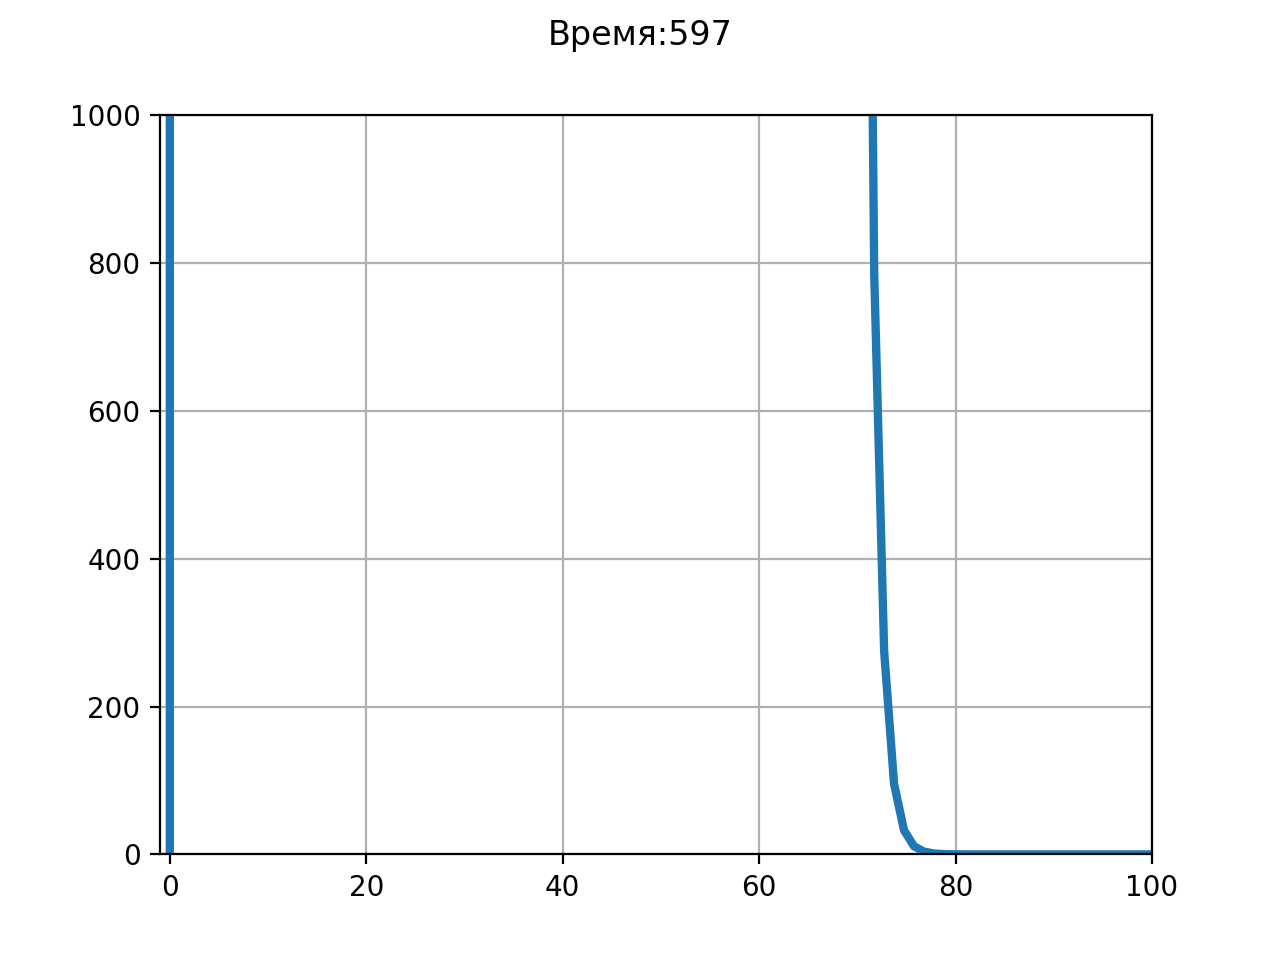

In [20]:
print("D = " + str(D) + ' a = ' + str(a) + " smert = " + str(smert) + " K0 = " + str(K) + " K1 = " + str(K1))
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 1000) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=50)
plt.grid(True)
plt.show()